Data Dictionary
Variable Name Description:

- Item_Identifier: Unique product ID
- Item_Weight: Weight of product
- Item_Fat_Content: Whether the product is low fat or regular
- Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product
- Item_Type: The category to which the product belongs
- Item_MRP: Maximum Retail Price (list price) of the product
- Outlet_Identifier: Unique store ID
- Outlet_Establishment_Year: The year in which store was established
- Outlet_Size: The size of the store in terms of ground area covered
- Outlet_Location_Type: The type of area in which the store is located
- Outlet_Type: Whether the outlet is a grocery store or some sort of supermarket
- Item_Outlet_Sales: Sales of the product in the particular store. This is the target variable to be predicted.

# Import

In [1]:
#Import
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
set_config(display='diagram')
## Importing Custom Functions
%reload_ext autoreload
%autoreload 2
from CODE import data_enrichment as de
filename = "Data/sales_predictions.csv"
df = pd.read_csv(filename)


# Functions

In [2]:
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')
  

In [3]:
def get_coefficients(lin_reg):
    coefs = lin_reg.coef_
    coefs = pd.Series(coefs, index=lin_reg.feature_names_in_)
    return coefs

In [4]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [5]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances



In [6]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [7]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax



In [8]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax


# Checking Versions

In [9]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


# Data Cleaning

How many Rows and Columns?

In [10]:
rows = len(df)
columns = len(df.columns)
print(f"There are {rows} rows and {columns} columns.")

There are 8523 rows and 12 columns.


-- or

In [11]:
df.shape

(8523, 12)

In [12]:
print(f"The datatype for rows is {type(rows)} and for columns it's {type(columns)}")

The datatype for rows is <class 'int'> and for columns it's <class 'int'>


-- Or

In [13]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

**Duplicates?**

- No duplicates no worries

In [14]:
df.duplicated().sum()

0

**Missing values?**

In [15]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

**Dropping Item_Identifier and Outlet_Identifier**

- Dropping the Outlet_Identifier because this particular data does not contribute to the sales predicitons, it's irrelevant to the items being sold.

- Then checking for removal of column with df.drop()

In [16]:
df = df.drop(columns= ["Outlet_Identifier", "Item_Identifier"])

df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
#Sucess!
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Filling Missing Data

- Checking for missing values.
- Then filling data for missing values and confirming change.

In [18]:
print(df.isna().sum())

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [19]:
mean_item_weight = df['Item_Weight'].mean()
df['Item_Weight'].fillna(mean_item_weight, inplace = True)
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [20]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Summary Statistics**

In [21]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Exploratory Visuals

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


C:\Users\caill\AppData\Local\Temp\ipykernel_10268\1528130796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


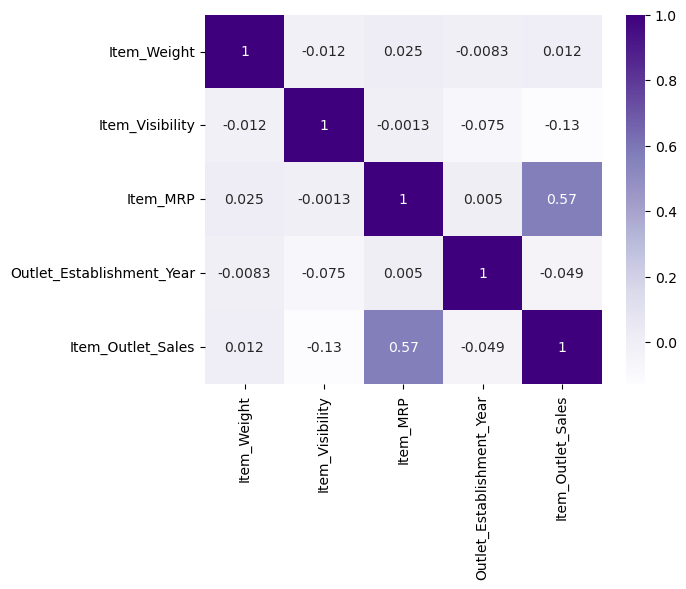

In [23]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Purples', annot = True)
plt.show()

- Checking to see which data has a positive or negative correlation.

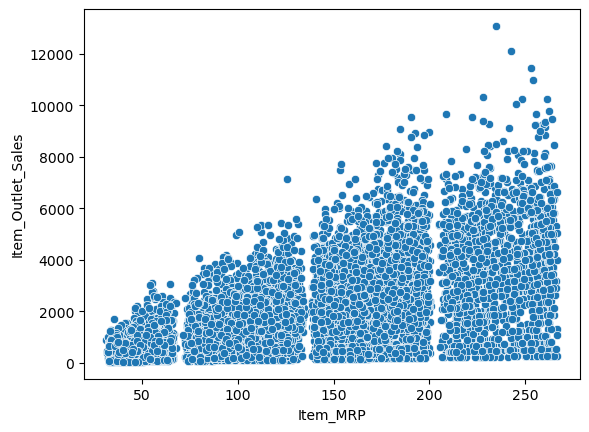

In [24]:
sns.scatterplot(data = df, x = "Item_MRP" , y = "Item_Outlet_Sales")
plt.show()

- This scatterplot shows a positive correlation between Item Outlet Sales and MRP (Highest list price). This means the higher the list price the higher the sale of that item.


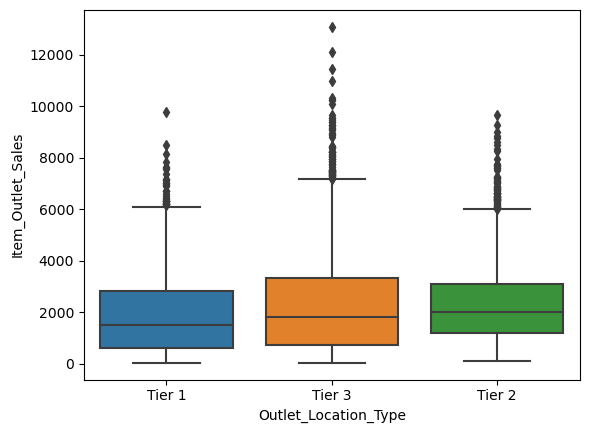

In [25]:
sns.boxplot(data = df, x = "Outlet_Location_Type", y = "Item_Outlet_Sales")
plt.show()

- The average sales are slightly made more at Tier 2 areas than the others. However there are many outliers above the max in all tiers to suggest otherwise.

# Explanatory Visuals

**Checking for styles**

In [26]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

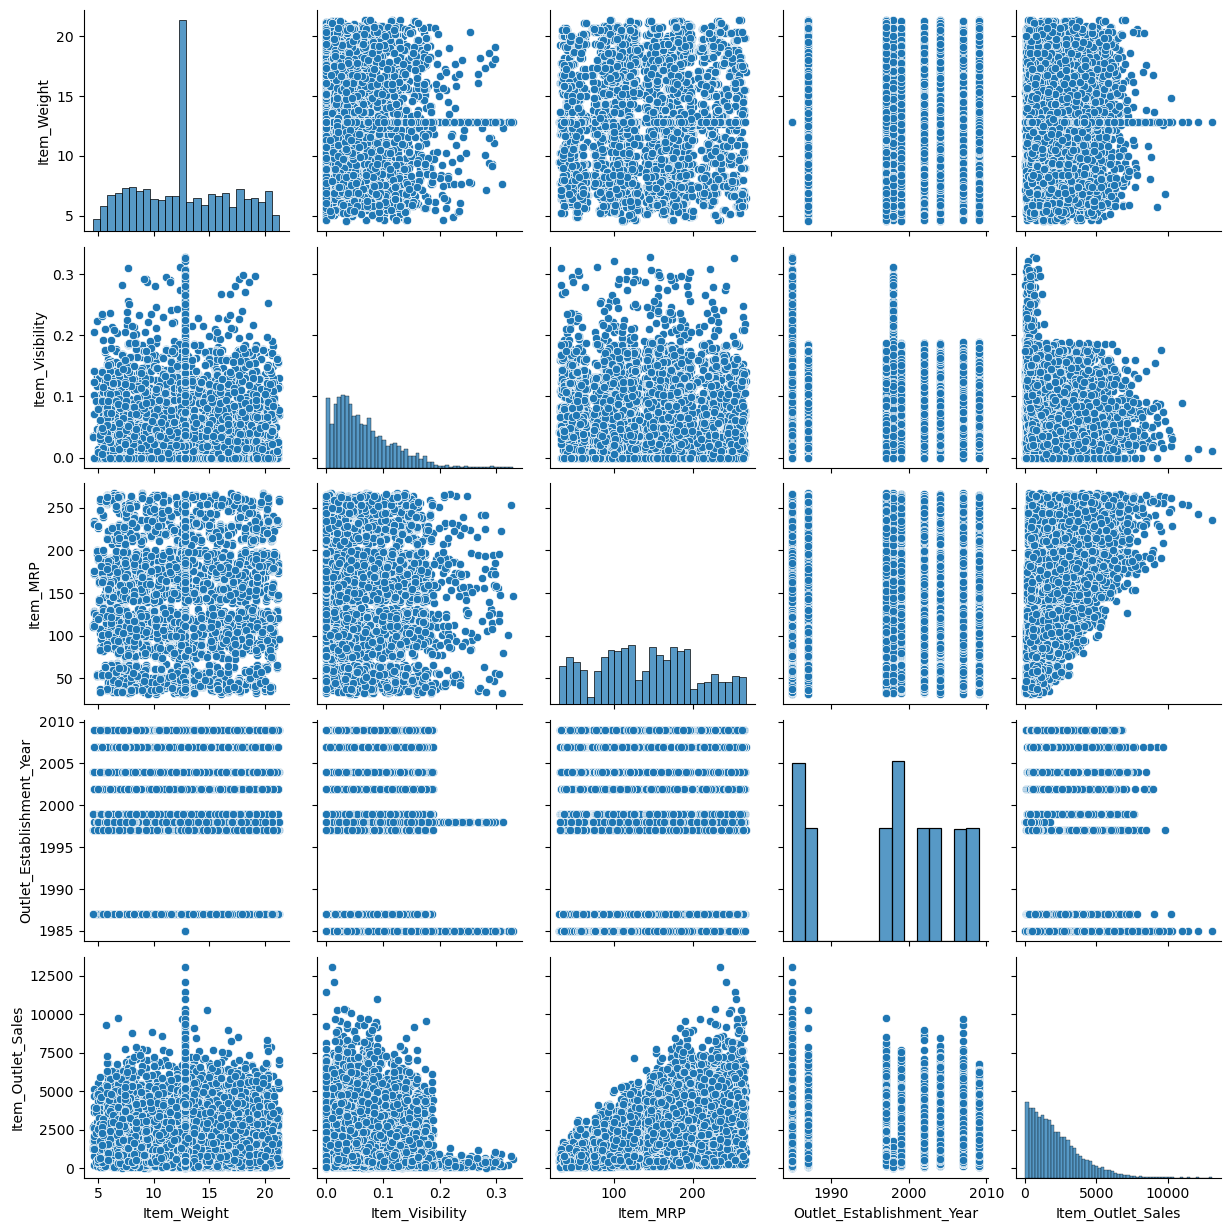

In [27]:
#checking for trends
sns.pairplot(df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


- Where have sales been since the start of the busines and what should be done to keep them at a steady rate?

In [29]:
plt.style.use("seaborn-darkgrid")

C:\Users\caill\AppData\Local\Temp\ipykernel_10268\1120890811.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


C:\Users\caill\AppData\Local\Temp\ipykernel_10268\3138454457.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = df, y ="Item_Outlet_Sales", x = "Outlet_Establishment_Year", ci = None, marker ="o")


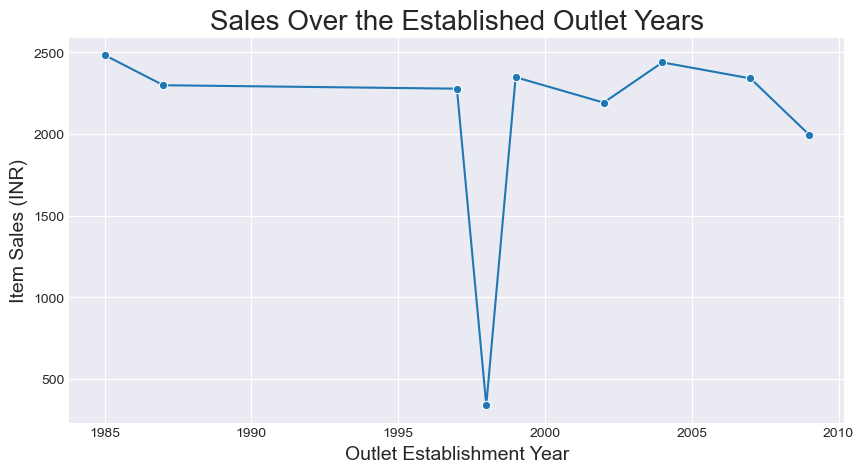

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data = df, y ="Item_Outlet_Sales", x = "Outlet_Establishment_Year", ci = None, marker ="o")
plt.xlabel("Outlet Establishment Year", fontsize = 14)
plt.ylabel("Item Sales (INR)", fontsize = 14)
plt.title("Sales Over the Established Outlet Years", fontsize = 20);
plt.show()

Data shows that sales have been fairly steady since 1985 but took a big dip in sales between 1995-2000. Afterwards data shows that sales shot back up and have been a bit rocky since then. 

Reccomendation : Find out why sales were shot down in between 1995-2000's and what was done differently to bring them back up. Recreate that situation and you may be able to keep sales steady again.

- Will people buy more of a product if it's cheaper?

C:\Users\caill\AppData\Local\Temp\ipykernel_10268\2152905913.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


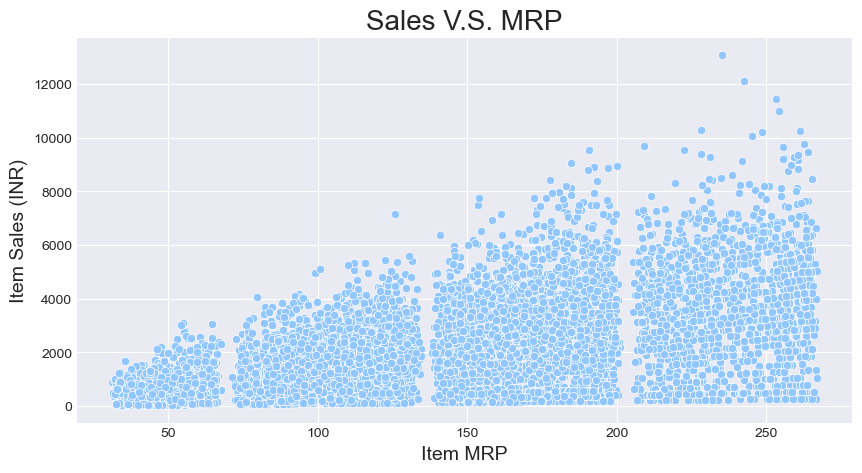

In [31]:
plt.style.use("seaborn-pastel")
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df, x ="Item_MRP", y = "Item_Outlet_Sales")
plt.title("Sales V.S. MRP", fontsize = 20)
plt.xlabel("Item MRP", fontsize = 14)
plt.ylabel("Item Sales (INR)", fontsize = 14)
plt.show()

The data shows more sales occur when the price of the item is higher.

Reccomendation: Make products that are not selling, higher in value. This may spark a change in sales.

# Machine Learning

In [32]:
#Define X and y
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()


#Train test split the data to prepare for machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.isna().any()


Item_Weight                  False
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
dtype: bool

In [33]:
df["Outlet_Size"].dropna(inplace = True)

In [34]:
#Create a ColumnTransformer to preprocess the data
cat_selector = make_column_selector(dtype_include = "object")
num_selector = make_column_selector(dtype_include ="number")

cat_selector(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [35]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

In [36]:
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [37]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [38]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [39]:
# create tuples of (imputer, selector) for each datatype
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)
# instantiate ColumnTransformer (processor)
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002448A6BCA00>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002448A157AF0>)])

In [40]:
#Transform your data and display the result.
col_transformer.fit(X_train)
X_train_imputed = col_transformer.transform(X_train)
X_test_imputed = col_transformer.transform(X_test)
# change the result back to a dataframe to find any missing data
#X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
#X_train_imputed.isna().any()

### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

from sklearn.pipeline import make_pipeline
reg_pipe = make_pipeline(scaler, reg)


In [42]:
#fit on imputed data (other data has null possibly)
reg_pipe.fit(X_train_imputed,y_train)

pred_test = reg_pipe.predict(X_test_imputed)
pred_train = reg_pipe.predict(X_train_imputed)

model_metrics(reg_pipe, X_train_imputed, y_train, X_test_imputed, y_test, model_name='Decision Regression')


Decision Regression Train Scores
MAE: 847.1957 
MSE: 1,298,632.5296 
RMSE: 1,139.5756 
R2: 0.5612

Decision Regression Test Scores
MAE: 803.9930 
MSE: 1,194,497.5596 
RMSE: 1,092.9307 
R2: 0.5671



In [43]:
###Regression Tree

dec_tree = DecisionTreeRegressor(random_state = 42)

dec_tree.fit(X_train_imputed, y_train)

train_preds = dec_tree.predict(X_train_imputed)
test_preds = dec_tree.predict(X_test_imputed)

In [44]:
# evaluating the model
train_score = dec_tree.score(X_train_imputed, y_train)
test_score = dec_tree.score(X_test_imputed, y_test)
print(train_score)
print(test_score)

1.0
0.18054765703238174


There seems to be an issue of overfitting in the decision tree. The R2 score in the training is higher than the testing data.

In [45]:
print(dec_tree.get_depth())

40


In [46]:
print(dec_tree.get_n_leaves())

6265


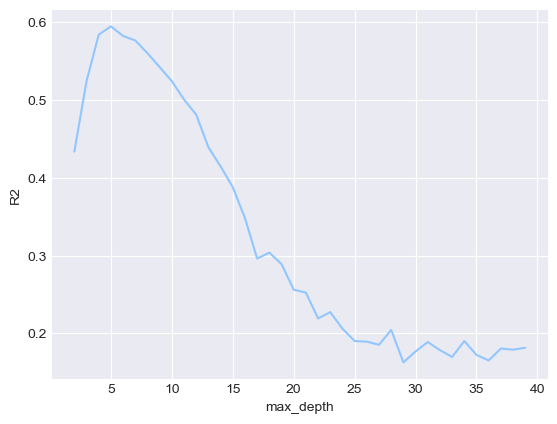

In [47]:
depths = list(range(2, 40)) # will try every value between 2 and 40

scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_imputed, y_train)
    train_score = dec_tree.score(X_train_imputed, y_train)
    test_score = dec_tree.score(X_test_imputed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [48]:
#Looking at wich depth precisely has the highest r2 test score
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582356,0.615072
7,0.576592,0.626454
8,0.560262,0.642714


In [49]:
#Using index with highest test score
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_imputed, y_train)
train_5_score = dec_tree_5.score(X_train_imputed, y_train)
test_5_score = dec_tree_5.score(X_test_imputed, y_test)
print(train_5_score)
print(test_5_score)
#Happy balance~

0.6039397477322956
0.5947099753159972


In [50]:
#R2 and RMSE Score for regression tree
model_metrics(dec_tree_5, X_train_imputed, y_train, X_test_imputed, y_test, model_name='Decision Regression')

Decision Regression Train Scores
MAE: 762.6102 
MSE: 1,172,122.7729 
RMSE: 1,082.6462 
R2: 0.6039

Decision Regression Test Scores
MAE: 738.3173 
MSE: 1,118,185.9731 
RMSE: 1,057.4431 
R2: 0.5947



The data fits better on the regression tree than the linear model and there are less penalized errors on the regression tree.

### Recommendation of which model to use

I recommend using the decision regression tree. The regression tree will be the best model to use due to the better fit and fewer errors.

# Linear Regression Feature Importance (Unscaled)

In [51]:
pd.set_option('display.max_columns',0)
df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [52]:
df.isna().sum()

Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [53]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


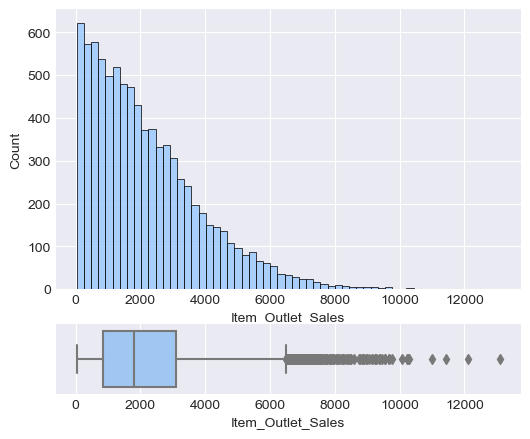

In [54]:
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

In [55]:
# ### Train Test Split
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = []

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.029565,Household,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.000000,Snack Foods,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.158716,Meat,157.2946,1999,Medium,Tier 1,Supermarket Type1


In [56]:
## Make categorical preprocessing pipeline
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [57]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [58]:
## make pipelines for categorical vs numeric data w/o scaling
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent', fill_value='MISSING'),
                         OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


In [59]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002448AA828B0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002448AA82FA0>)],
                  verbose_feature_names_out=False)

In [60]:
## fit column transformer and run get_feature_names_out
#preprocessor.fit(X_train)
#feature_names = preprocessor.get_feature_names_out()
#feature_names

In [61]:
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.350,0.029565,256.4646,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7510,15.250,0.000000,179.7660,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,12.350,0.158716,157.2946,1999.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,7.975,0.014628,82.3250,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4810,19.350,0.016645,120.9098,2002.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,9.395,0.286345,139.1838,1998.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5191,15.600,0.117575,75.6670,2007.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5390,17.600,0.018944,237.3590,2002.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
860,20.350,0.054363,117.9466,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


# Model 1

In [62]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1139.58
Test Data:	R^2= 0.57	RMSE= 1092.93


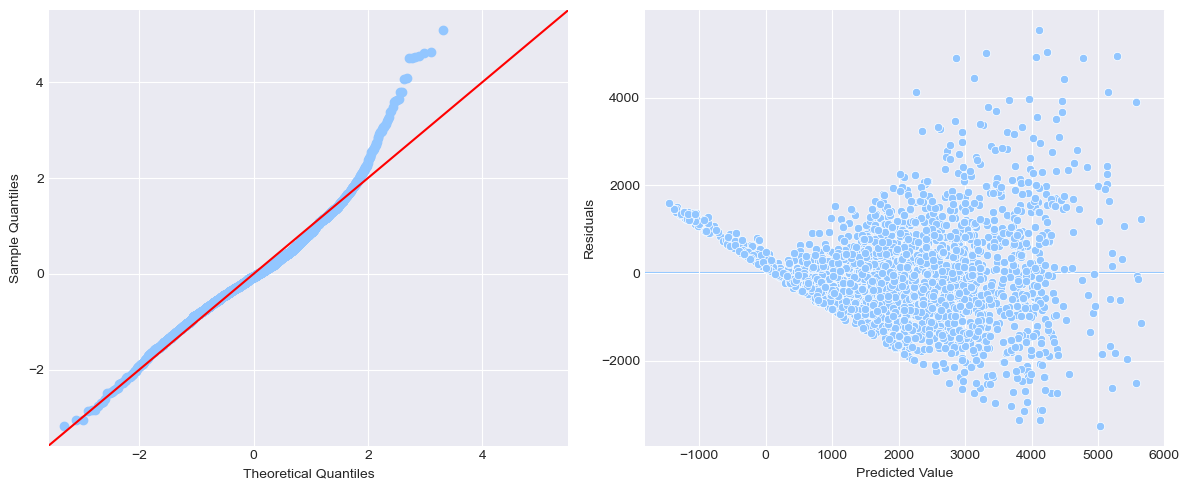

In [63]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [64]:
# access the .coef_ 
coeffs = lin_reg.coef_
coeffs

array([-1.86996365e+00, -4.23333708e+02,  1.57230000e+01,  3.45285301e+01,
        6.19603607e+01, -2.35724010e+01,  4.72361981e+01,  2.89271813e+01,
       -1.05311316e+02, -1.98696500e+00,  4.79127440e+01,  1.82825876e+01,
        2.74640429e+01,  5.76801945e+00, -9.85702667e+00, -2.82300899e+01,
        3.29234586e+02, -1.94871690e+01, -3.88365265e+01,  4.62313285e+01,
       -8.61328312e+02, -7.98679685e+02, -1.97345282e+02, -4.17308538e+02,
        1.51148490e+03,  1.27818149e+03,  3.81474408e+03])

In [65]:
# Intercept
intercept = lin_reg.intercept_
intercept

-69552.21064087968

In [66]:
get_coefficients(lin_reg)

Item_Weight                          -1.869964
Item_Visibility                    -423.333708
Item_MRP                             15.723000
Outlet_Establishment_Year            34.528530
Item_Fat_Content_Regular             61.960361
Item_Type_Breads                    -23.572401
Item_Type_Breakfast                  47.236198
Item_Type_Canned                     28.927181
Item_Type_Dairy                    -105.311316
Item_Type_Frozen Foods               -1.986965
Item_Type_Fruits and Vegetables      47.912744
Item_Type_Hard Drinks                18.282588
Item_Type_Health and Hygiene         27.464043
Item_Type_Household                   5.768019
Item_Type_Meat                       -9.857027
Item_Type_Others                    -28.230090
Item_Type_Seafood                   329.234586
Item_Type_Snack Foods               -19.487169
Item_Type_Soft Drinks               -38.836527
Item_Type_Starchy Foods              46.231328
Outlet_Size_Medium                 -861.328312
Outlet_Size_S

In [67]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [68]:
## Saving the coefficients
coefs = pd.Series(coeffs, index=lin_reg.feature_names_in_)
coefs

Item_Weight                          -1.87
Item_Visibility                    -423.33
Item_MRP                             15.72
Outlet_Establishment_Year            34.53
Item_Fat_Content_Regular             61.96
Item_Type_Breads                    -23.57
Item_Type_Breakfast                  47.24
Item_Type_Canned                     28.93
Item_Type_Dairy                    -105.31
Item_Type_Frozen Foods               -1.99
Item_Type_Fruits and Vegetables      47.91
Item_Type_Hard Drinks                18.28
Item_Type_Health and Hygiene         27.46
Item_Type_Household                   5.77
Item_Type_Meat                       -9.86
Item_Type_Others                    -28.23
Item_Type_Seafood                   329.23
Item_Type_Snack Foods               -19.49
Item_Type_Soft Drinks               -38.84
Item_Type_Starchy Foods              46.23
Outlet_Size_Medium                 -861.33
Outlet_Size_Small                  -798.68
Outlet_Location_Type_Tier 2        -197.35
Outlet_Loca

In [69]:
#Show sorted coefficients
coefs.sort_values()

Outlet_Size_Medium                 -861.33
Outlet_Size_Small                  -798.68
Item_Visibility                    -423.33
Outlet_Location_Type_Tier 3        -417.31
Outlet_Location_Type_Tier 2        -197.35
Item_Type_Dairy                    -105.31
Item_Type_Soft Drinks               -38.84
Item_Type_Others                    -28.23
Item_Type_Breads                    -23.57
Item_Type_Snack Foods               -19.49
Item_Type_Meat                       -9.86
Item_Type_Frozen Foods               -1.99
Item_Weight                          -1.87
Item_Type_Household                   5.77
Item_MRP                             15.72
Item_Type_Hard Drinks                18.28
Item_Type_Health and Hygiene         27.46
Item_Type_Canned                     28.93
Outlet_Establishment_Year            34.53
Item_Type_Starchy Foods              46.23
Item_Type_Breakfast                  47.24
Item_Type_Fruits and Vegetables      47.91
Item_Fat_Content_Regular             61.96
Item_Type_S

In [70]:
coeff_ranks = coefs.abs().rank().sort_values(ascending=False)
coeff_ranks

Outlet_Type_Supermarket Type3     27.00
Outlet_Type_Supermarket Type1     26.00
Outlet_Type_Supermarket Type2     25.00
Outlet_Size_Medium                24.00
Outlet_Size_Small                 23.00
Item_Visibility                   22.00
Outlet_Location_Type_Tier 3       21.00
Item_Type_Seafood                 20.00
Outlet_Location_Type_Tier 2       19.00
Item_Type_Dairy                   18.00
Item_Fat_Content_Regular          17.00
Item_Type_Fruits and Vegetables   16.00
Item_Type_Breakfast               15.00
Item_Type_Starchy Foods           14.00
Item_Type_Soft Drinks             13.00
Outlet_Establishment_Year         12.00
Item_Type_Canned                  11.00
Item_Type_Others                  10.00
Item_Type_Health and Hygiene       9.00
Item_Type_Breads                   8.00
Item_Type_Snack Foods              7.00
Item_Type_Hard Drinks              6.00
Item_MRP                           5.00
Item_Type_Meat                     4.00
Item_Type_Household                3.00


- Outlet_Type_Supermarket Type 3 is the most important to the target but Type 1 & 2 are also almost equally important.

In [71]:
## Get a list of all of the Item_Type columns
item_types = [i for i in X_train_df.columns if i.startswith('Item_Type')]
item_types

['Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods']

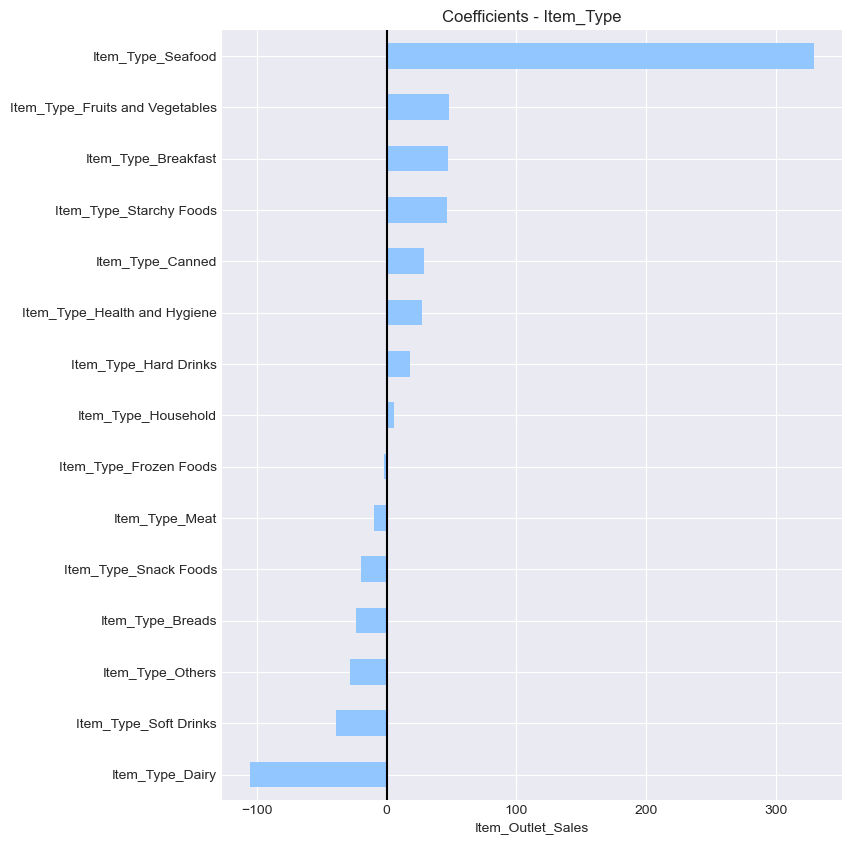

In [72]:
ax = coefs[item_types].sort_values().plot(kind='barh', figsize=(8,10))
ax.axvline(0, color='k')
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Item_Type");

- In Item_Type the most more seafood has a positive effect on sales and more dairy has a negative effect.

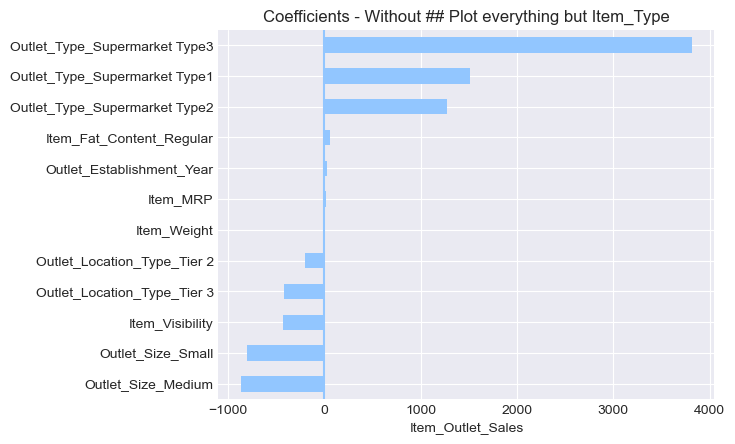

In [73]:
## Plot everything but countries
ax = coefs.drop(item_types).sort_values().plot(kind='barh')#, figsize=(8,26))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Without ## Plot everything but Item_Type");

- Intercept: Our model assumed a baseline score of -69,552.21
- Unscaled:
   - Positive:
   - Outlet_Type_Supermarket:
      - Type 3: This coefficient tells us that adding a Type 3 supermarket increases sales by $3,814.74.
      
      - Type 1: Adding a Type 1 supermarket increases sales by $1,511.49.
           
     - Type 2: Adding a Type 2 supermarket increases sales by $1,278.18.

# Model 2

In [74]:
lin_reg= LinearRegression(fit_intercept=False)
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1140.36
Test Data:	R^2= 0.57	RMSE= 1094.83


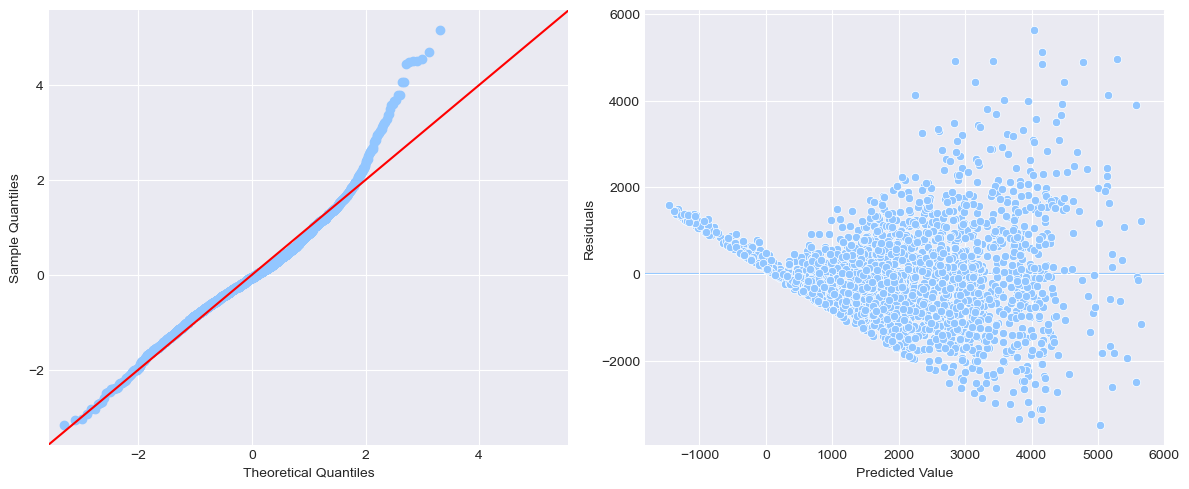

In [75]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [76]:
coeffs = lin_reg.coef_
coeffs

array([-1.76050309e+00, -4.27189901e+02,  1.57168504e+01, -9.06186322e-01,
        6.32913366e+01, -3.00171358e+01,  4.69882127e+01,  2.57827627e+01,
       -1.06577412e+02, -2.07983356e+00,  4.35517017e+01,  1.20649594e+01,
        2.68244177e+01,  3.21097119e+00, -9.86754063e+00, -3.23147598e+01,
        3.18172174e+02, -2.12903673e+01, -4.17650929e+01,  4.62860220e+01,
       -3.28302137e+01, -1.06023719e+01,  2.07718721e+01,  1.73479105e+00,
        1.95063779e+03,  1.66822646e+03,  3.35434699e+03])

In [77]:
get_coefficients(lin_reg)

Item_Weight                          -1.76
Item_Visibility                    -427.19
Item_MRP                             15.72
Outlet_Establishment_Year            -0.91
Item_Fat_Content_Regular             63.29
Item_Type_Breads                    -30.02
Item_Type_Breakfast                  46.99
Item_Type_Canned                     25.78
Item_Type_Dairy                    -106.58
Item_Type_Frozen Foods               -2.08
Item_Type_Fruits and Vegetables      43.55
Item_Type_Hard Drinks                12.06
Item_Type_Health and Hygiene         26.82
Item_Type_Household                   3.21
Item_Type_Meat                       -9.87
Item_Type_Others                    -32.31
Item_Type_Seafood                   318.17
Item_Type_Snack Foods               -21.29
Item_Type_Soft Drinks               -41.77
Item_Type_Starchy Foods              46.29
Outlet_Size_Medium                  -32.83
Outlet_Size_Small                   -10.60
Outlet_Location_Type_Tier 2          20.77
Outlet_Loca

In [78]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [79]:
## Saving the coefficients
coeffs_noint = pd.Series(coeffs, index=lin_reg.feature_names_in_)
coeffs_noint

Item_Weight                          -1.76
Item_Visibility                    -427.19
Item_MRP                             15.72
Outlet_Establishment_Year            -0.91
Item_Fat_Content_Regular             63.29
Item_Type_Breads                    -30.02
Item_Type_Breakfast                  46.99
Item_Type_Canned                     25.78
Item_Type_Dairy                    -106.58
Item_Type_Frozen Foods               -2.08
Item_Type_Fruits and Vegetables      43.55
Item_Type_Hard Drinks                12.06
Item_Type_Health and Hygiene         26.82
Item_Type_Household                   3.21
Item_Type_Meat                       -9.87
Item_Type_Others                    -32.31
Item_Type_Seafood                   318.17
Item_Type_Snack Foods               -21.29
Item_Type_Soft Drinks               -41.77
Item_Type_Starchy Foods              46.29
Outlet_Size_Medium                  -32.83
Outlet_Size_Small                   -10.60
Outlet_Location_Type_Tier 2          20.77
Outlet_Loca

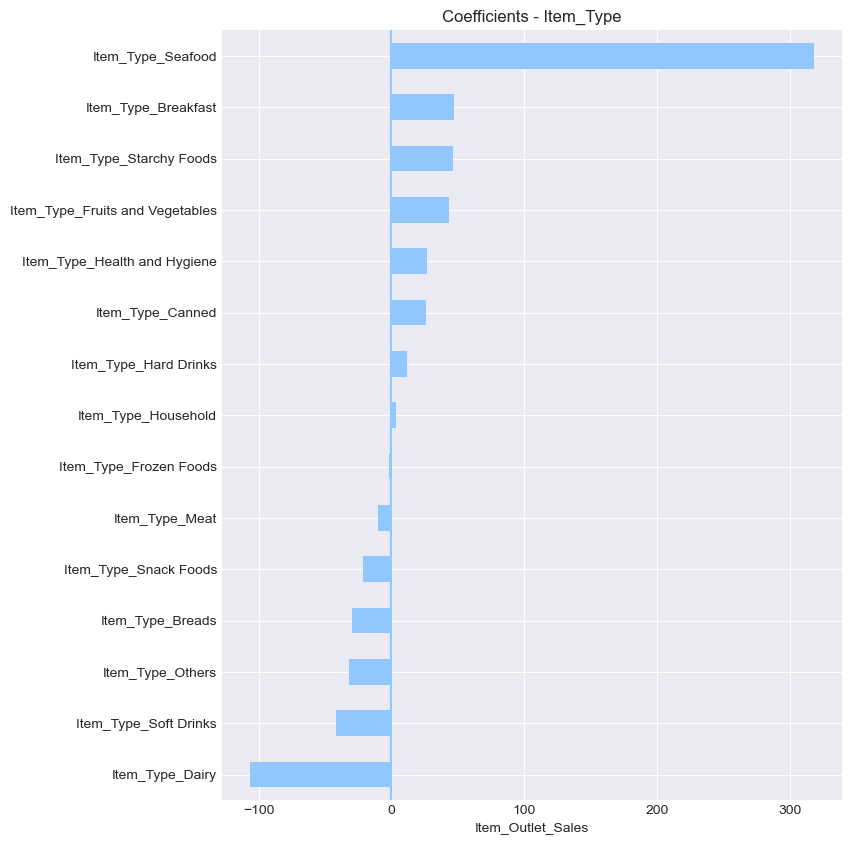

In [80]:
ax = coeffs_noint[item_types].sort_values().plot(kind='barh', figsize=(8,10))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Item_Type");
fig_gcf = plt.gcf()

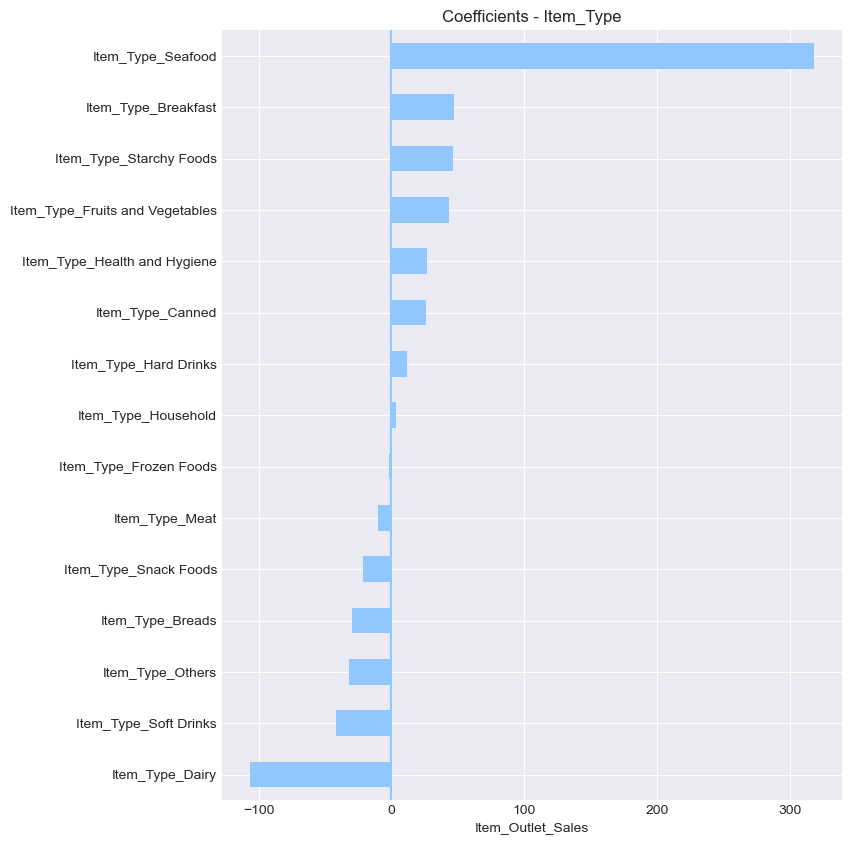

In [81]:
fig_gcf

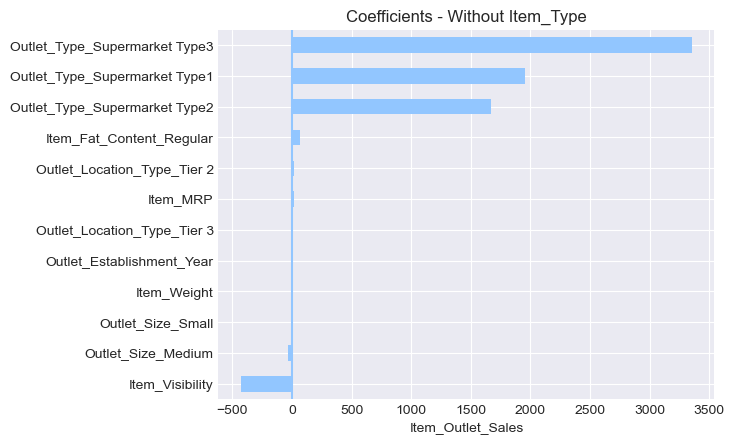

In [82]:
## Plot everything but countries
ax = coeffs_noint.drop(item_types).sort_values().plot(kind='barh')#, figsize=(8,26))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Without Item_Type");

# Model #3 - No Item_Type

In [83]:
# ### Train Test Split
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = ["Item_Type"]

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [84]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)

In [85]:
lin_reg_no = LinearRegression(fit_intercept=False)
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1141.33
Test Data:	R^2= 0.57	RMSE= 1091.57


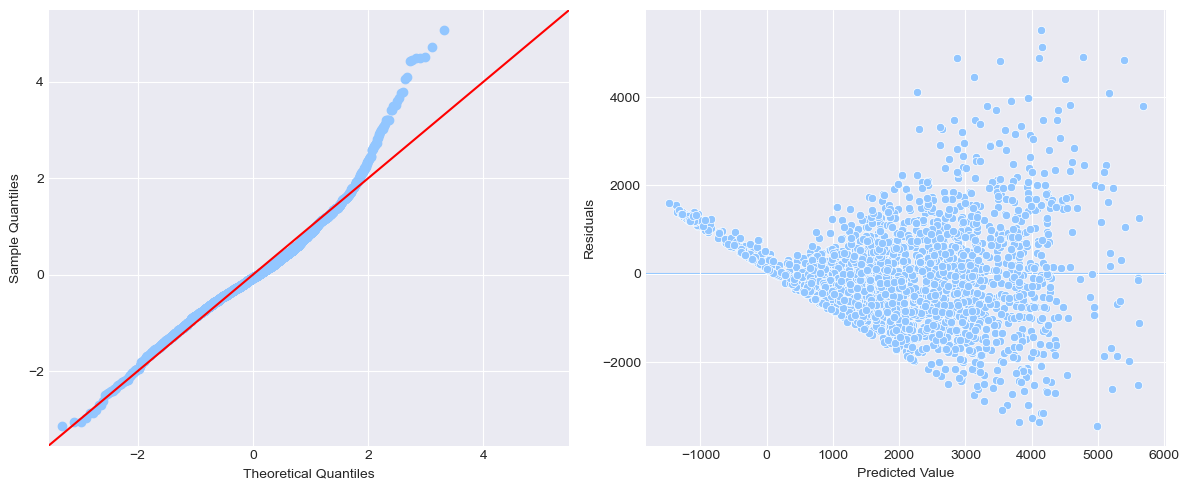

In [86]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [87]:
coeffs_3 = get_coefficients(lin_reg)
coeffs_3.sort_values()

Item_Visibility                  -451.95
Outlet_Size_Medium                -26.95
Outlet_Size_Small                  -5.09
Item_Weight                        -1.85
Outlet_Establishment_Year          -0.91
Outlet_Location_Type_Tier 3         6.42
Item_MRP                           15.69
Outlet_Location_Type_Tier 2        20.85
Item_Fat_Content_Regular           65.38
Outlet_Type_Supermarket Type2   1,667.37
Outlet_Type_Supermarket Type1   1,954.58
Outlet_Type_Supermarket Type3   3,354.80
dtype: float64

<AxesSubplot: >

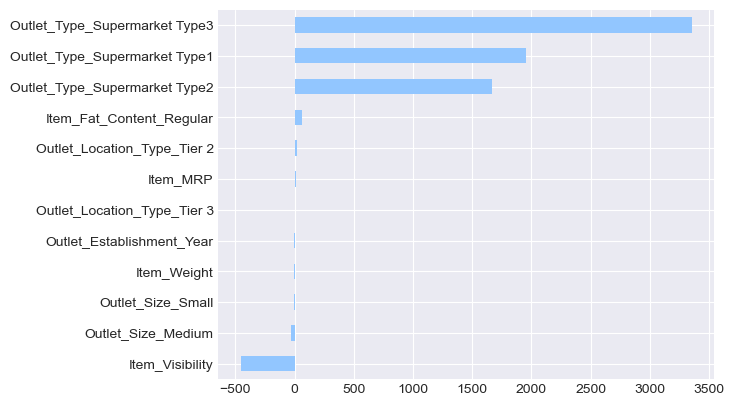

In [88]:
coeffs_3.sort_values().plot(kind='barh')

In [89]:
lin_reg.intercept_

0.0

# Model 3: Dropping First Duplicate Categories with OneHotEncoder

In [90]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False,
                                      ))
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder', OneHotEncoder(drop='first', sparse=False))])

In [91]:
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)
display(X_train_df.head())

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,0.03,256.46,"2,009.00",0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
7510,15.25,0.00,179.77,"2,009.00",1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
5828,12.35,0.16,157.29,"1,999.00",1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
5327,7.97,0.01,82.33,"2,004.00",0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00
4810,19.35,0.02,120.91,"2,002.00",0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00


Training Data:	R^2= 0.56	RMSE= 1140.58
Test Data:	R^2= 0.57	RMSE= 1091.01


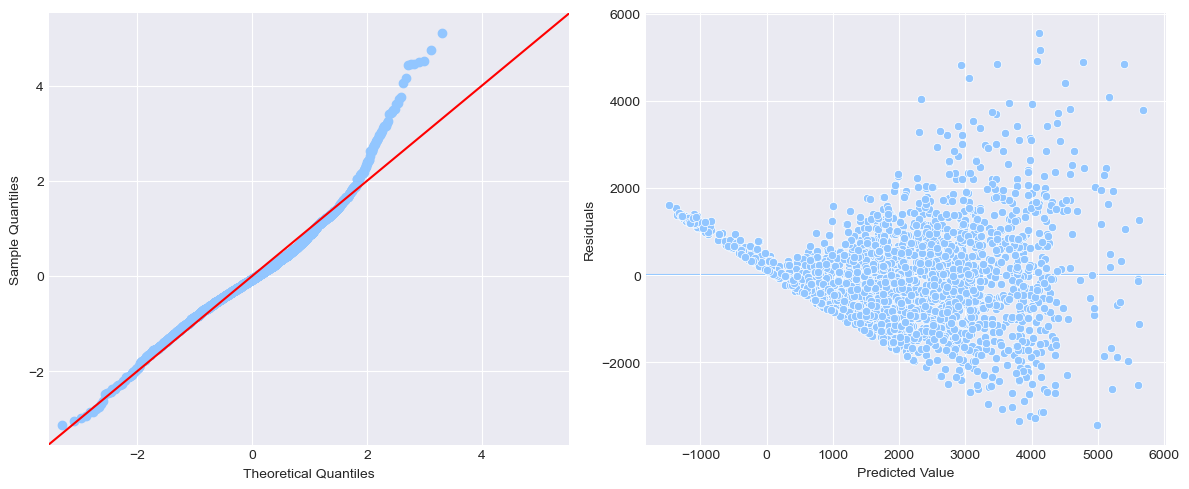

In [92]:
lin_reg_drop = LinearRegression(fit_intercept=False)
lin_reg_drop.fit(X_train_df,y_train)
evaluate_regression(lin_reg_drop, X_train_df, y_train, 
                    X_test_df, y_test)

de.plot_residuals(lin_reg_drop, X_test_df,y_test)
fig_gcf = plt.gcf()

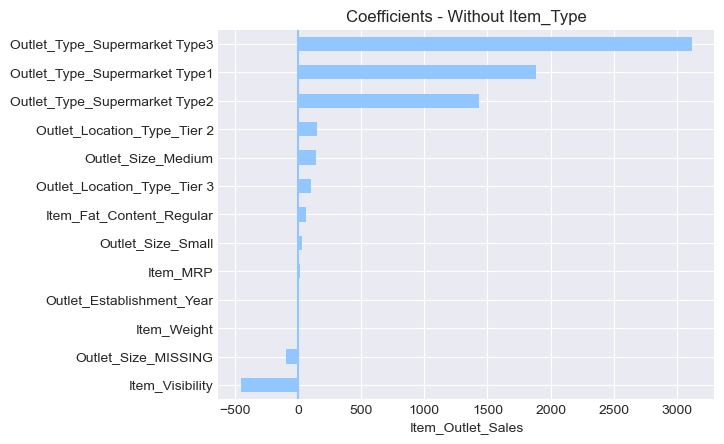

In [93]:
# extract and plot coefficients without countries
coeffs_dropped = get_coefficients(lin_reg_drop)


ax = coeffs_dropped.sort_values().plot(kind='barh')#, figsize=(8,26))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Without Item_Type");
fig_gcf2 = plt.gcf()

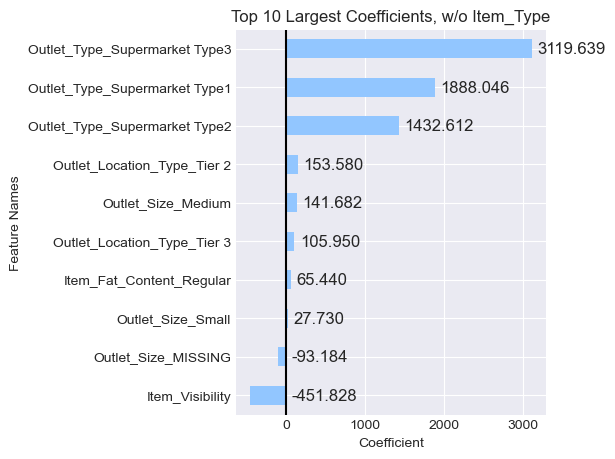

In [94]:
ax = plot_coeffs(coeffs_dropped,top_n=10, annotate=True);
ax.set_title('Top 10 Largest Coefficients, w/o Item_Type');
fig_gcf2 = plt.gcf()

# Random Regression

In [95]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 427.32
Test Data:	R^2= 0.55	RMSE= 1116.73


In [96]:
importances = pd.Series(rf_reg.feature_importances_, index=rf_reg.feature_names_in_)
importances.sort_values()

Outlet_Location_Type_Tier 2     0.00
Outlet_Location_Type_Tier 3     0.00
Outlet_Size_MISSING             0.00
Outlet_Size_Small               0.01
Item_Fat_Content_Regular        0.01
Outlet_Type_Supermarket Type2   0.02
Outlet_Size_Medium              0.03
Outlet_Establishment_Year       0.04
Item_Weight                     0.07
Outlet_Type_Supermarket Type1   0.09
Outlet_Type_Supermarket Type3   0.11
Item_Visibility                 0.13
Item_MRP                        0.47
dtype: float64

In [97]:
get_importances(rf_reg)

Item_Weight                     0.07
Item_Visibility                 0.13
Item_MRP                        0.47
Outlet_Establishment_Year       0.04
Item_Fat_Content_Regular        0.01
Outlet_Size_MISSING             0.00
Outlet_Size_Medium              0.03
Outlet_Size_Small               0.01
Outlet_Location_Type_Tier 2     0.00
Outlet_Location_Type_Tier 3     0.00
Outlet_Type_Supermarket Type1   0.09
Outlet_Type_Supermarket Type2   0.02
Outlet_Type_Supermarket Type3   0.11
Name: Feature Importance, dtype: float64

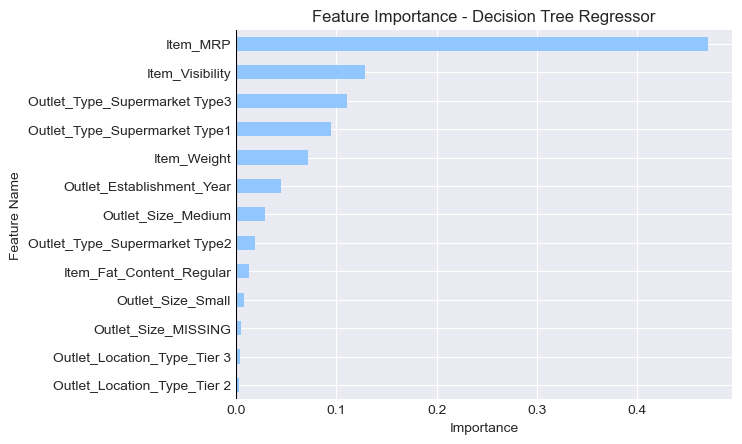

In [98]:
ax = importances.sort_values().plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');
fig_gcf4 = plt.gcf()

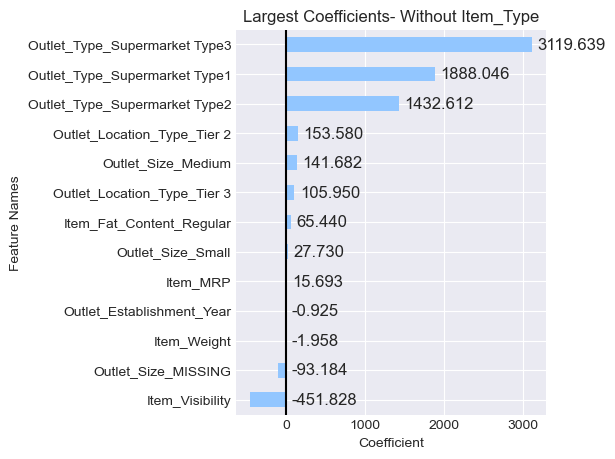

In [99]:
coeffs_dropped = get_coefficients(lin_reg_drop)

ax = plot_coeffs(coeffs_dropped, annotate=True);
ax.set_title("Largest Coefficients- Without Item_Type");
fig_gcf5 = plt.gcf()

In [100]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,256.46,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,179.77,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,157.29,1999,Medium,Tier 1,Supermarket Type1
5327,7.97,Low Fat,0.01,82.33,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,120.91,2002,NaN,Tier 2,Supermarket Type1


In [101]:
evaluate_regression(lin_reg_drop,X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1140.58
Test Data:	R^2= 0.57	RMSE= 1091.01


In [110]:
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 427.32
Test Data:	R^2= 0.55	RMSE= 1116.73


In [111]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg_drop,
          'RandomForestRegressor':rf_reg}


In [112]:
folder = 'Models/'
os.makedirs(folder, exist_ok=True)

In [113]:
fname=folder + 'best-models.joblib'
joblib.dump(export, fname)

['Models/best-models.joblib']

In [114]:
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])